# MRIO Workshop

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
var_list = ['Z', 'V', 'Y', 'F_NRG', 'F_NRG_hh', 'F_GHG', 'F_GHG_hh']
Z, V, Y, F_NRG, F_NRG_hh, F_GHG, F_GHG_hh, year_list = [], [], [], [], [], [], [], []

for var in var_list:
    for year in range(1995, 2010):
        if year not in year_list:
            year_list.append(year)
        if var.split('_')[0] == 'F' and var.split('_')[-1] != 'hh':
            my_col = 0
        else:
             my_col = [0, 1]
        if var.split('_')[-1] == 'hh':
            my_header = 0
        else:
            my_header = [0, 1]
            
        df = pd.read_csv('Data/clean_data/' + var + '_' + str(year) + '.csv', header=my_header, index_col=my_col).dropna(how='all', axis=0)
        eval(var).append(df)
        
# ensure that indecies match up

new_names = {'ROM':'ROU', 'RoW':'ROW', 'c1':'c01', 'c2':'c02', 'c3':'c03', 'c4':'c04', 'c5':'c05', 'c6':'c06', 'c7':'c07', 'c8':'c08', 'c9':'c09'}
for i in range(len(year_list)):
    Y[i] = Y[i].rename(columns=new_names, index=new_names).swaplevel(axis=1)
    Y[i] = Y[i].reindex(sorted(Y[i].columns), axis=1).reindex(sorted(Y[i].index), axis=0)
    
    Z[i] = Z[i].rename(columns=new_names, index=new_names)
    Z[i] = Z[i].reindex(sorted(Z[i].columns), axis=1).reindex(sorted(Z[i].index), axis=0)
    
    V[i] = V[i].rename(columns=new_names, index=new_names)
    V[i] = V[i].reindex(sorted(V[i].columns), axis=1).reindex(sorted(V[i].index), axis=0)
    
    F_NRG[i] = F_NRG[i].rename(columns=new_names, index=new_names)
    F_NRG[i] = F_NRG[i].reindex(sorted(F_NRG[i].columns), axis=1)
    F_GHG[i] = F_GHG[i].rename(columns=new_names, index=new_names)
    F_GHG[i] = F_GHG[i].reindex(sorted(F_GHG[i].columns), axis=1)
    
    F_NRG_hh[i] = F_NRG_hh[i].reindex(Y[i].index.levels[0], axis=1)
    F_GHG_hh[i] = F_GHG_hh[i].reindex(Y[i].index.levels[0], axis=1)

# 5. Calculating energy and emissions consumption-based accounts

For reference, use:  
http://www.see.leeds.ac.uk/teaching-resources/exercise-pages/l4-input-output-tutorial-201617/  
http://mathesaurus.sourceforge.net/matlab-numpy.html 

### 5.1. The UK's production and consumption based GHG emissions from 1995-2009

In [3]:
UK_consumption = []
UK_production = []
for i in range(len(year_list)):
    # territorial emissions
    UK_prod = float(F_GHG[i]['GBR'].sum(axis=1)) + float(F_GHG_hh[i]['GBR'])
    UK_production.append(UK_prod)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(F_GHGx, L)
    temp = np.matmul(temp, Y_UK)
    
    UK_cons = temp + float(F_GHG_hh[i]['GBR'])
    UK_consumption.append(UK_cons[0][0])

In [4]:
UK_co2e = pd.DataFrame()
UK_co2e['Consumption'] = UK_consumption
UK_co2e['Production'] = UK_production
UK_co2e['Year'] = year_list

Text(0.5,1,'UK')

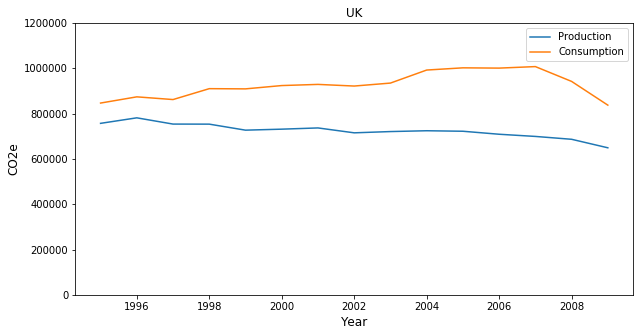

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_co2e.plot(ax=ax, x='Year', y='Production')
UK_co2e.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2e', fontsize=12)
ax.set_ylim([0,1200000])
ax.set_title('UK')

### 5.2. What proportion of the Global total is the production and consumption energy account of the BRIC countries (Brazil, Russia, India & China) for the years 1995-2009?

In [6]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
country_list = F_NRG_hh[0].columns.tolist()

BRIC_consumption = []
BRIC_production = []
for i in range(len(year_list)):
    # territorial emissions
    BRIC_prod = float(F_NRG[i][BRIC_countries].sum(axis=1)) + float(F_NRG_hh[i][BRIC_countries].sum(axis=1))
    global_prod = float(F_NRG[i].sum(axis=1)) + float(F_NRG_hh[i].sum(axis=1))
    BRIC_production.append(BRIC_prod/global_prod * 100)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    temp_1 = np.matmul(F_NRGx, L)
    
    BRIC_cons = 0
    global_cons = 0
    for c in country_list:
        Y_temp = np.array(Y[i][[c]]).sum(axis=1).reshape(1435, 1)
        temp_2 = np.matmul(temp_1, Y_temp)
        cons = temp_2 + float(F_NRG_hh[i][[c]].sum(axis=1))
        global_cons += cons[0][0]
        if c in BRIC_countries:
            BRIC_cons += cons[0][0]
        
    BRIC_consumption.append(BRIC_cons/global_cons * 100)

In [7]:
BRIC_energy = pd.DataFrame()
BRIC_energy['Consumption'] = BRIC_consumption
BRIC_energy['Production'] = BRIC_production
BRIC_energy['Year'] = year_list

Text(0.5,1,'BRIC Countries')

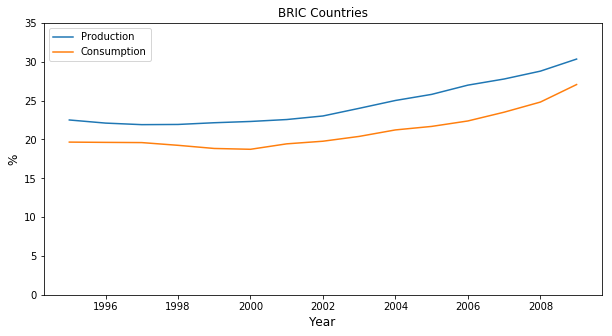

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

BRIC_energy.plot(ax=ax, x='Year', y='Production')
BRIC_energy.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,35])
ax.set_title('BRIC Countries')

### 5.3. What proportion of the UK’s GHG footprint is sourced from BRIC nations?

In [9]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
UK_BRIC = []
sectors = 35

for i in range(len(year_list)):
    x = np.array(Z[i].sum(axis=1) + Y[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    BRIC_value = 0
    for c in BRIC_countries:
        temp_1 = temp.T[c].sum().sum()
        BRIC_value += temp_1
    
    UK_BRIC.append(BRIC_value/UK_consumption[i] * 100)   

In [10]:
UK_BRIC_ghg = pd.DataFrame()
UK_BRIC_ghg['BRIC_prop'] = UK_BRIC
UK_BRIC_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - BRIC Proportion')

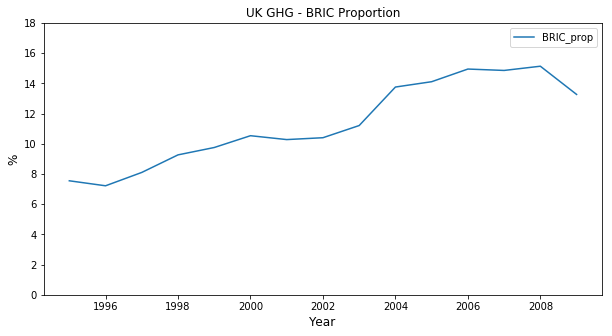

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_BRIC_ghg.plot(ax=ax, x='Year', y='BRIC_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,18])
ax.set_title('UK GHG - BRIC Proportion')

### 5.4. What proportion of UK’s GHG footprint can be shown to originate from the agricultural industry?

In [12]:
UK_agriculture = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    agri_value = temp.T.swaplevel(axis=1)['c01'].sum().sum()
    
    UK_agriculture.append(agri_value/UK_consumption[i] * 100)   

In [13]:
UK_agri_ghg = pd.DataFrame()
UK_agri_ghg['agri_prop'] = UK_agriculture
UK_agri_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - Agriculture Proportion')

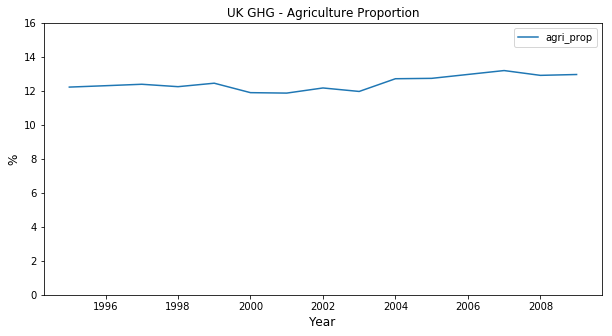

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_agri_ghg.plot(ax=ax, x='Year', y='agri_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,16])
ax.set_title('UK GHG - Agriculture Proportion')

In [15]:
# above answer is off by about 1% for each year .. 

### 6.1. Make Y_G8 a ‘1 x 1435’ vector showing the final demand of the G8 nations and use this to find the total energy footprint of G8 nations 

In [116]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
final_demand = len(Y[0].columns.levels[1].tolist())
G8_Y_agg = np.zeros((regions*final_demand, 1))
G8_lookup = np.zeros((regions,1))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_Y_agg[(j*final_demand)-final_demand:j*final_demand] = np.ones((final_demand,1))

In [117]:
G8_energy_cons = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    Y_G8 = np.matmul(np.array(Y[i]),  G8_Y_agg)
    
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_G8)
    
    temp_1 = np.matmul(np.array(F_NRG_hh[i]), G8_lookup)
    
    G8_cons = temp[0][0] + temp_1[0][0]
    
    G8_energy_cons.append(G8_cons)

In [128]:
G8_cons_nrg = pd.DataFrame()
G8_cons_nrg['G8'] = G8_energy_cons
G8_cons_nrg['Year'] = year_list

Text(0.5,1,'G8')

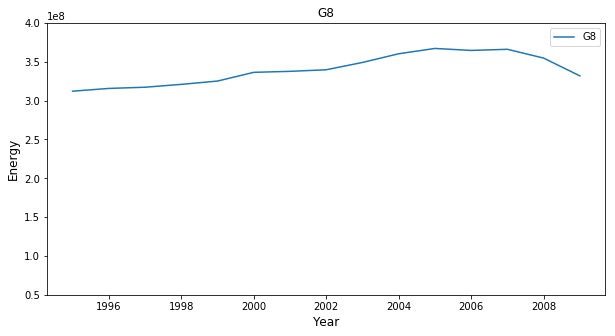

In [129]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='G8')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([50000000, 400000000])
ax.set_title('G8')

### 6.2. What proportion of the UK energy footprint is sourced from G8 nations?

Using aggregate matrices

In [84]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())

G8_lookup = np.zeros((regions,1))
G8_F_agg = np.zeros((1,regions*sectors))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_F_agg[0][(j*sectors)-sectors:j*sectors] = np.ones((sectors,1)).reshape(1, sectors)[0]

In [122]:
UK_G8_prop = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)
    
    # UK energy footprint
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))  
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_UK)
    UK_cons = temp + float(F_NRG_hh[i]['GBR'])
    
    # from G8
    F_G8 = G8_F_agg * np.array(F_NRG[i])
    F_G8x = F_G8 / (x.reshape(1, 1435))
    temp = np.matmul(F_G8x, L)
    temp = np.matmul(temp, Y_UK)
    
    a = temp[0][0] / UK_cons[0][0] * 100
    
    UK_G8_prop.append(a)

Text(0.5,1,'UK NRG - G8 Proportion')

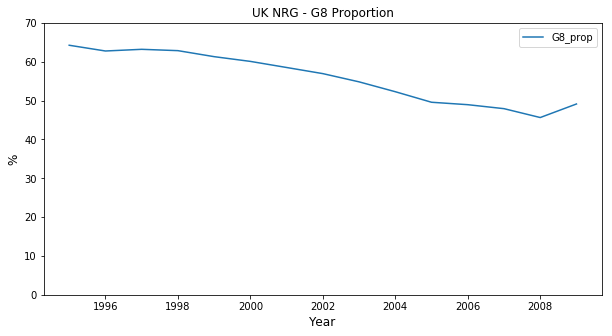

In [123]:
UK_G8_prop_df = pd.DataFrame()
UK_G8_prop_df['G8_prop'] = UK_G8_prop
UK_G8_prop_df['Year'] = year_list

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_G8_prop_df.plot(ax=ax, x='Year', y='G8_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,70])
ax.set_title('UK NRG - G8 Proportion')

### 6.3. Making a smaller version of the WIOD matrix using aggregation matrices

In [124]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())
final_demand = len(Y[1].columns.levels[1].tolist())

G8_lookup = np.zeros((regions, 1))
G8_agg = np.zeros((2*sectors, regions*sectors))
G8_Y_agg = np.zeros((2*final_demand, final_demand*regions))
    
for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_agg[0:sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
        G8_Y_agg[0:final_demand, j*final_demand-(final_demand):j*final_demand] = np.identity(final_demand)
        
    else:
        G8_agg[sectors:2*sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
        G8_Y_agg[final_demand:2*final_demand, j*final_demand-(final_demand):j*final_demand] = np.identity(final_demand)
        
G8_Y_agg = np.matrix.transpose(G8_Y_agg)

In [125]:
G8_energy_cons_agg = []

for i in range(len(year_list)):
    C_t = np.matrix.transpose(G8_agg)
    new_Z = np.matmul(np.matmul(G8_agg, Z[i]), C_t)
    new_F = np.matmul(np.array(F_NRG[i]), C_t)
    new_Y = np.matmul(np.matmul(G8_agg, Y[i]), G8_Y_agg)
    
    x = np.array(new_Y.sum(axis=1) + new_Z.sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(70, 1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(new_Z) / x_t
    I = np.identity(len(new_Z))
    L = np.linalg.inv(I-A)
    
    Y_G8 = np.array(new_Y[:, :5]).sum(axis=1)
    Y_G8 = Y_G8.reshape(Y_G8.shape[0], 1)
    
    # G8 energy footprint
    F_NRGx = new_F / (x.reshape(x.shape[1], x.shape[0]))  
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_G8)
    G8_cons = temp + float(F_NRG_hh[i][G8].sum(axis=1))
    
    G8_energy_cons_agg.append(G8_cons[0][0])

Text(0.5,1,'UK NRG - G8 Proportion')

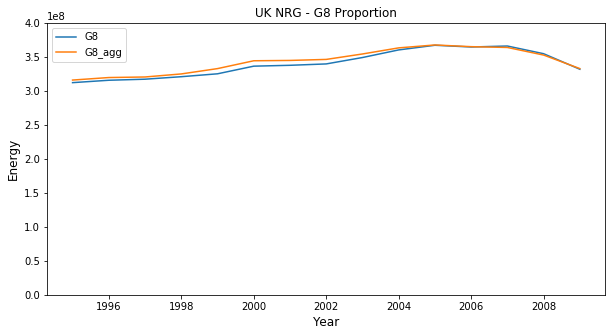

In [130]:
G8_cons_nrg['G8_agg'] = G8_energy_cons_agg

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='G8')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([0, 400000000])
ax.set_title('UK NRG - G8 Proportion')

### 6.4. Making an even smaller version of the WIOD matrix

In [174]:
file_loc = 'Data/WIOT/wiot' + str(1995)[2:] + '_row_apr12.xlsx'
    
# import data
df = pd.read_excel(file_loc, index_col=None, header=None).iloc[2:6].T
df = df.loc[df[4] == 'AUS']
df[4] = df[5]
df.loc[df[5].map(str).apply(len) == 2, 4] = 'c0' + df[5].str[-1]

In [176]:
extraction_from_nature = ['AtB', 'C']
manufacturing = ['15t16', '17t18', '19', '20', '21t22', '23', '24', '25', '26', '27t28', '29', '30t33', '34t35', '36t37']
fuel = ['E']
construction = ['F']
trade = ['50', '51', '52', 'H']
transport = ['60', '61', '62']
public_services = ['J', '70', '71t74']
public_services_other = ['L', 'M', 'N', 'O', 'P']

In [ ]:
#### make aggreagtion matrix for new secotrs

industries = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())
final_demand = len(Y[1].columns.levels[1].tolist())

G8_lookup = np.zeros((regions, 1))
G8_agg = np.zeros((2*sectors, regions*sectors))
G8_Y_agg = np.zeros((2*final_demand, final_demand*regions))
    
for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_agg[0:sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
        G8_Y_agg[0:final_demand, j*final_demand-(final_demand):j*final_demand] = np.identity(final_demand)
        
    else:
        G8_agg[sectors:2*sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
        G8_Y_agg[final_demand:2*final_demand, j*final_demand-(final_demand):j*final_demand] = np.identity(final_demand)
        
G8_Y_agg = np.matrix.transpose(G8_Y_agg)

In [175]:
Z[0]

AUS                            \
                                            c01          c02          c03   
('country', 'TOT') (nan, 'sector')                                          
AUS                c01              3107.030501    12.291245  8043.698877   
                   c02                28.959657  2105.924299   152.077325   
                   c03               895.456175    12.231363  2865.513885   
                   c04                28.273938    14.701817    41.198731   
                   c05                 0.622581     0.016827     0.013222   
                   c06                20.091805    11.520247     3.472266   
                   c07                80.882523    60.596371   489.024059   
                   c08               195.138371   261.604156    20.895568   
                   c09               791.936974   238.218015    39.197794   
                   c10                42.533140    76.485289   533.187082   
                   c11                16.078079    27.614133   103.871820   
                   c12               108.127949   476.658694   525.410717   
                   c13               143.227744   441.676962    13.367535   
                   c14                22.810458    40.433552    21.041637   
                   c15                56.754445    68.082511     7.662298   
                   c16                26.065152    62.255028    20.890105   
                   c17               246.373039   522.591096   562.885034   
                   c18               304.495782   296.231933    12.871316   
                   c19               601.360064   382.142593   282.649287   
                   c20              1315.834577   814.189826  2353.642390   
                   c21               913.343094   561.071980  1653.713902   
                   c22               175.815980   176.240600   421.164730   
                   c23               714.504551   630.293145  1638.657525   
                   c24                13.494800    71.039080    29.850410   
                   c25                33.733618    75.739896    56.015978   
                   c26               181.980890   122.832817   422.878234   
                   c27               247.107898   258.686441   220.091558   
                   c28               612.838322   489.560468   390.846984   
                   c29               114.625794   294.912945   140.016248   
                   c30               577.410738  1049.596997  1134.836771   
...                                         ...          ...          ...   
USA                c06                 0.283554     0.162224     0.064542   
                   c07                 3.792619     4.111673    23.852982   
                   c08                 9.222599     8.686959     0.808337   
                   c09               111.321108    33.849003     6.314677   
                   c10                 2.322096     4.048748    24.716434   
                   c11                 0.234974     0.394405     1.164123   
                   c12                 2.019556     6.184092     6.753107   
                   c13                27.874013    85.695844     2.915839   
                   c14                13.078554    33.310452     4.745907   
                   c15                 6.642924     9.262350     0.698971   
                   c16                 0.907177     1.776899     0.588113   
                   c17                 0.084890     0.027303     0.095331   
                   c18                 0.000030     0.000030     0.000000   
                   c19                 0.000054     0.000034     0.000027   
                   c20                 0.072855     0.044969     0.130330   
                   c21                 0.000055     0.000035     0.000027   
                   c22                 0.011480     0.011488     0.027513   
                   c23                 2.531261     2.207253     5.798125   
                   c24                 0